In [26]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit


In [5]:
fraud_df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/fraud.csv', 
                 parse_dates = ['signup_time','purchase_time'])
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
fraud_df.is_fraud.replace({1: -1}, inplace=True)
fraud_df.is_fraud.replace({0: 1}, inplace=True)

/Users/francois/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

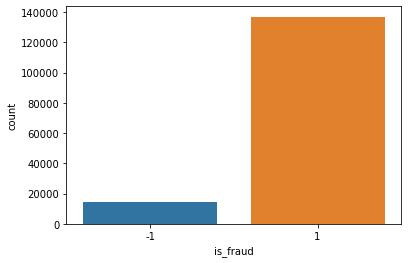

In [7]:
target = fraud_df["is_fraud"]
sns.countplot(target)

In [9]:
fraud_df = fraud_df[fraud_df['purchase_time']>'2015-02-01'].reset_index(drop=True)
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,1
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,1
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,1
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,1


/Users/francois/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

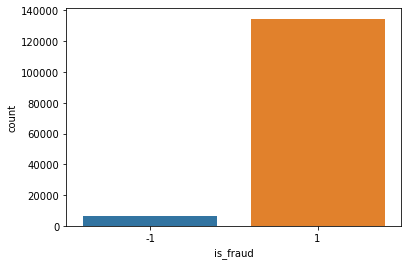

In [10]:
target = fraud_df["is_fraud"]
sns.countplot(target)

In [12]:
df_inliers = fraud_df[fraud_df['is_fraud'] == 1]
df_outliers = fraud_df[fraud_df['is_fraud'] == -1]

target = fraud_df["is_fraud"]

print(df_inliers.shape)
print(df_outliers.shape)
print(fraud_df.shape)

(134587, 11)
(6428, 11)
(141015, 11)


In [13]:
proportionFraud = fraud_df[fraud_df["is_fraud"] == -1].is_fraud.count()/fraud_df.is_fraud.count()
proportionFraud

0.04558380314150977

In [24]:
def process_df(original_df):
    df = original_df.copy()
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for cat_col in ['device_id','source','browser','sex']:
        cat_mapper = dict(zip(df[cat_col].unique(), range(1, len(df[cat_col].unique())+1)))
        df[cat_col] = df[cat_col].replace(cat_mapper)
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_weekDay'] = df[f'{col_prefix}_time'].dt.dayofweek
        df[f'cos_{col_prefix}_weekDay'] = np.cos(2.*np.pi*df[f'{col_prefix}_weekDay']/7.)
        df[f'sin_{col_prefix}_weekDay'] = np.sin(2.*np.pi*df[f'{col_prefix}_weekDay']/7.)
        df = df.drop(columns=[f'{col_prefix}_time'])
    return df

In [25]:
processed_fraud_df = process_df(fraud_df)

In [40]:
x_df = processed_fraud_df.loc[:, processed_fraud_df.columns != 'is_fraud'].reset_index(drop=True)
y_df = processed_fraud_df[['is_fraud']]

gs = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=123)

train_indexes, test_indexes = next(gs.split(x_df, y_df, groups=x_df.user_id))

x_train = x_df.iloc[train_indexes]
y_train = y_df.iloc[train_indexes]

x_test = x_df.iloc[test_indexes]
y_test = y_df.iloc[test_indexes]

y_test = np.squeeze(y_test)

In [41]:
isof = IsolationForest(contamination = 0.05, n_estimators = 100, n_jobs = -1)

In [42]:
isof.fit(x_train)

y_pred = isof.predict(x_test)

pd.crosstab(y_test, y_pred, rownames = ["Classes réelles"], colnames = ["Classes prédites"])

Classes prédites,-1,1
Classes réelles,,
-1,67,1236
1,1322,25578


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.05      0.05      0.05      1303
           1       0.95      0.95      0.95     26900

    accuracy                           0.91     28203
   macro avg       0.50      0.50      0.50     28203
weighted avg       0.91      0.91      0.91     28203



In [44]:
# On découpe manuellement nos jeux de données de validation croisée au sein de l'échantillon d'apprentissage
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(x_train, y_train))
forest = IsolationForest()

# Dans la situation où on ne connait pas à priori le paramètre de contamination,
# on ajoute la contamination dans la grille de recherche

resc = make_scorer(recall_score,pos_label = -1)

params = {"contamination":np.linspace(0.01,0.05,10),
          "n_estimators": [100,200,300]}

search = GridSearchCV(estimator=forest, param_grid=params, scoring=resc, cv=folds, n_jobs=-1)
search.fit(x_train, y_train)

# predict
optimal_forest = search.best_estimator_
y_pred = optimal_forest.predict(x_test)


pd.crosstab(y_test,y_pred, rownames = ["Classes réelles"], colnames = ["Classes prédites"])

Classes prédites,-1,1
Classes réelles,,
-1,78,1225
1,1266,25634


In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.06      0.06      0.06      1303
           1       0.95      0.95      0.95     26900

    accuracy                           0.91     28203
   macro avg       0.51      0.51      0.51     28203
weighted avg       0.91      0.91      0.91     28203

